### Validation Metrics

For any XML response that failed to validate.

The dataset for processing is the set of XML responses that contained a @schemaLocation or @noNamespaceLocation or DTD reference. No effort was made to identify the validity of those references - these are captured in the validation error text.

Documents were validated using PParse (requires an internal reference to the schema, no effort was made to guess the appropriate schema - these vary over time 

Basic questions:

1. How many errors per file?
2. How many errors per file **if** the validator was able to successfully connect to the remotely-hosted schema(s)?
3. How do both #1 and #2 change over time?
4. Change by protocol (only ISO and FGDC are identified)?

In [2]:
%matplotlib inline
import pandas as pd
import json as js  # name conflict with sqla
import sqlalchemy as sqla
from sqlalchemy.orm import sessionmaker

In [3]:
# grab the clean text from the rds
with open('../local/big_rds.conf', 'r') as f:
    conf = js.loads(f.read())

# our connection
engine = sqla.create_engine(conf.get('connection'))

In [ ]:
# return the overall percentages (valid vs invalid).
sql = '''
select valid, cnt, 100.0*cnt/(sum(cnt) OVER ()) as pct
from (select valid, count(*) as cnt from validations group by valid) foo;
'''

In [4]:
# number of errors with host, protocol and metadata date
sql = '''with i as 
(
    select d.response_id, jsonb_array_elements(d.identity::jsonb) ident
    from identities d
    where d.identity is not null
)
select r.id, r.host, r.metadata_age,
    array_length(v.errors, 1) as number_of_errors,
    i.ident->'protocol' as protocol
from responses r 
    right outer join validations as v on v.response_id = r.id
    left outer join i on i.response_id = r.id
where v.valid = False;
'''

In [5]:
df = pd.read_sql(sql, engine, index_col='id', parse_dates=['metadata_age'])

In [10]:
df.count()

host                47240
metadata_age         7354
number_of_errors    47240
protocol             9807
dtype: int64

From our subset of all invalid things (running roughly 25-30%). 



#### Basic Summary Stats

In [5]:
# summary statistics for the errors
df.describe()

,number_of_errors
count,47288.000000
mean,79.367408
std,1218.844696
min,1.000000
25%,2.000000
50%,2.000000
75%,7.000000
max,68376.000000


The error count of 1 often (not always) indicates a failed schema retrieval. Let's see what this looks like.

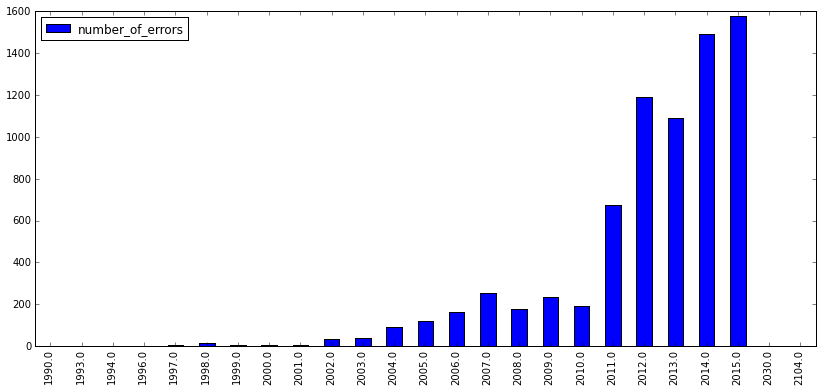

In [6]:
df[['number_of_errors']].groupby(df['metadata_age'].dt.year).count().plot(kind="bar", figsize=(14, 6))

In [32]:
# bin the things
freq = dict(df['number_of_errors'].value_counts())
df_freq = pd.DataFrame(list(freq.iteritems()), columns=['value', 'frequency'])

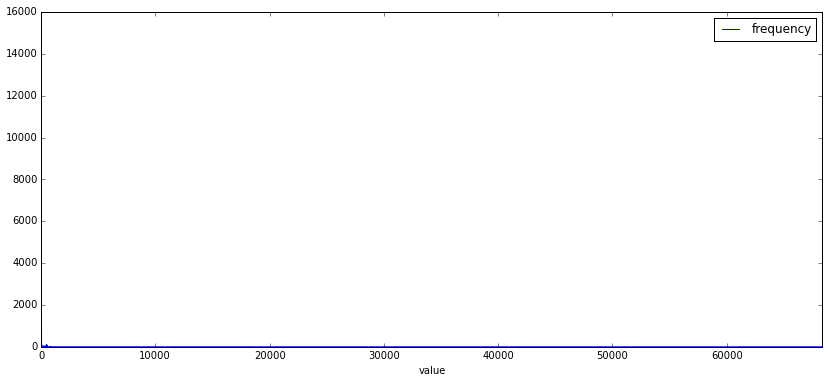

In [48]:
df_freq.sort('value').plot(kind='line', x='value', y='frequency', figsize=(14, 6))

# this is not going well, matplotlib. 

In [45]:
df_freq.to_csv('outputs/error_frequency.csv')

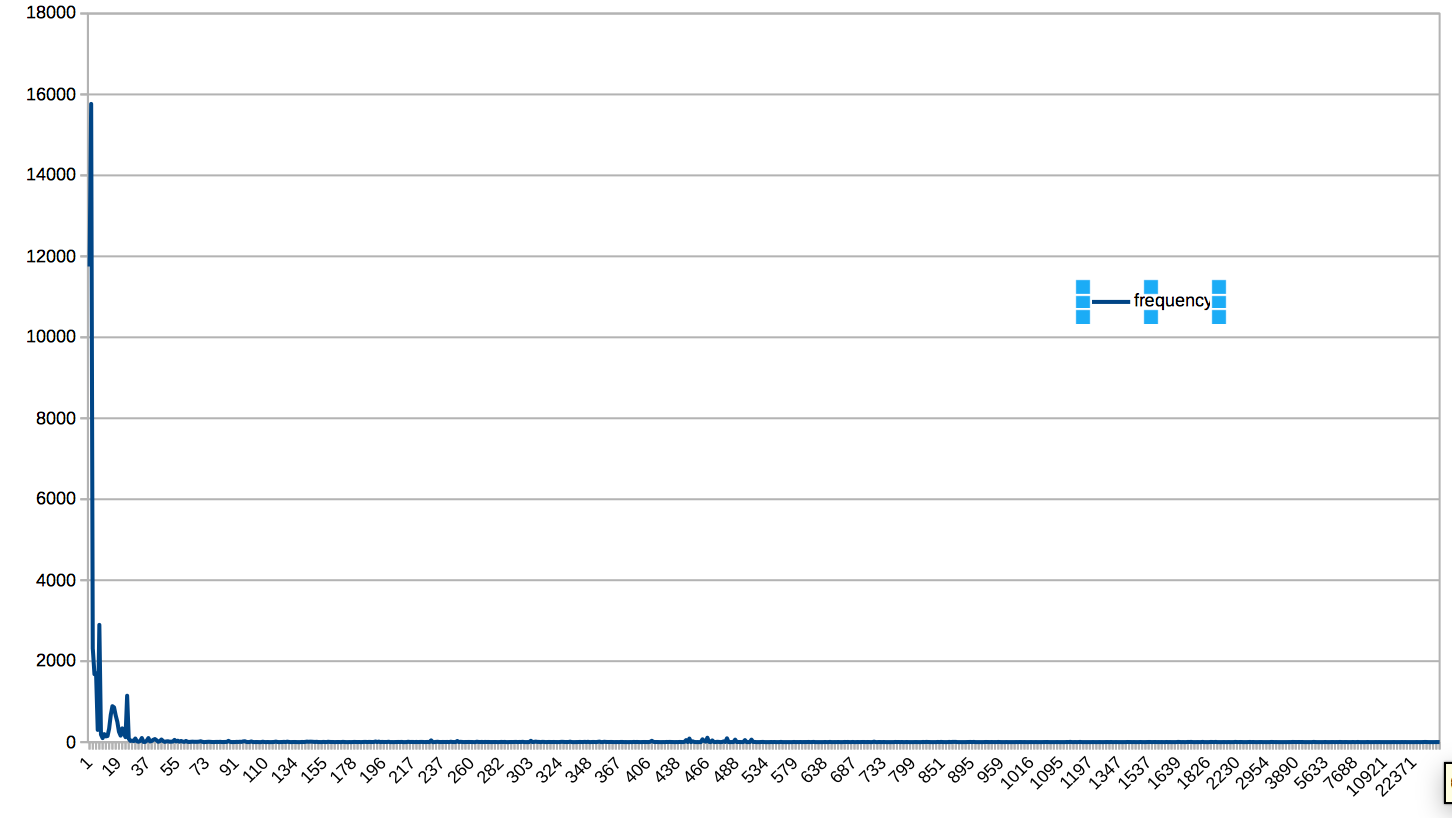

In [46]:
from IPython.display import Image
Image(filename='screenshots/error_frequency.png') 

# the image from libreoffice

Not sure about raw error count here.  

### Types of Validation errors

Patterns from the stderr outputs (not intended for real use, gathered in an ad-hoc manner just to understand the data).

```
with v as (
	select response_id, unnest(errors) as every_error
	from validations
	where valid = False
)

select distinct every_error
from v
where (every_error not like '% attribute % is not declared %'
	and every_error not like '% no declaration found for element %'
	and every_error not like '% element % is not allowed for content model %'
	and every_error not like '% empty content is not valid for content model %'
	and every_error not like '% missing elements in content model %'
	and every_error not like '% schemaLocation does not contain namespace-location pairs%'
	and every_error not like '% no character data is allowed by content model%'
	and every_error not like '% unable to find validator for%'
	and every_error not like '% grammar not found for namespace %'
	and every_error not like '% element % is referenced in a content model but was never declared%'
	and every_error not like '% no complete functional mapping between particles%'
	and every_error not like '% namespace for % cannot be bound to prefix other than %'
	and every_error not like '% root element name of XML Schema document must be %'
	and every_error not like '% element % must be from the XML Schema namespace%'
	and every_error not like '% namespace % is referenced without import declaration%'
	and every_error not like '% imported schema % has different target namespace %; expected %'
	and every_error not like '% schema document % has different target namespace from the one specified in instance document %'
	and every_error not like '% markup declaration expected%'
	and every_error not like '% invalid multi-byte sequence%'
	and every_error not like '% unsupported protocol in URL%'
)
and (
-- remove the nots for the access errors
	every_error not like '% fatal error during schema scan%'
	and every_error not like '% reference to external entity declaration %'
	and every_error not like '% unable to open DTD document%'
	and every_error not like '% unable to connect socket for URL %'
	and every_error not like '% unable to read from socket for URL %'
	and every_error not like '% unable to open file %'
	and every_error not like '% unable to open primary document entity %'
	and every_error not like '% unable to open external entity %'
	and every_error not like '% unable to resolve host/address %'
)
and (
	every_error not like '% empty string encountered%'
	and every_error not like '% value % is invalid ENTITY%'
	and every_error not like '% value % is invalid NCName%'
	and every_error not like '% value % is invalid QName%'
	and every_error not like '% value % is invalid Name%'
	and every_error not like '% ID value % is not unique%'
	and every_error not like '% ID value % has already been used%'
	and every_error not like '% value % not in enumeration%'
	and every_error not like '% value % does not match regular expression facet%'
	and every_error not like '% invalid character encountered%'
	and every_error not like '% element % must be qualified%'
	and every_error not like '% element % must be unqualified%'
	and every_error not like '% attribute % must be unqualified%'
	and every_error not like '% missing required attribute %'
	and every_error not like '% missing % separator in dateTime value %'
	and every_error not like '% value % is invalid boolean%'
	and every_error not like '% value % does not match any member types of the union%'
	and every_error not like '% incomplete time value %'
	and every_error not like '% invalid time value %'
	and every_error not like '% invalid dateTime value %'
	and every_error not like '% value % has length % which is less than minLength facet value %'
	and every_error not like '% attribute % has already been declared%'
	and every_error not like '% ID attribute % is referenced but was never declared%'
	and every_error not like '% specified for non-nillable element %'
	and every_error not like '% element % is of simple type and cannot have elements in its content%'
	and every_error not like '% value % must be greater than or equal to minExclusive facet value %'
	and every_error not like '% value % must be greater than or equal to minInclusive facet value %'
	and every_error not like '% attribute % declared more than once in the same scope%'
	and every_error not like '% attribute % refers to unknown entity %'
	and every_error not like '% attribute % is already specified for element %'
	and every_error not like '% year value % must follow % format%'
	and every_error not like '% month value % must be between 1 and %'
	and every_error not like '% duration value % must start with %'
	and every_error not like '% value % is invalid anyURI%'
	and every_error not like '% global element % declared more than once%'
	and every_error not like '% content of element % differs from its declared fixed value%'
	and every_error not like '% whitespace must not occur between externally declared elements with element content in standalone document%'
	and every_error not like '% attribute cannot have empty value%'
	and every_error not like '% value % must be less than maxExclusive facet value %'
	and every_error not like '% value % must be less than maxInclusive facet value %'
	and every_error not like '% value % must be less than or equal to maxInclusive facet value %'
	and every_error not like '% day value % must be between 1 and %'
	and every_error not like '% global type % declared more than once or also declared as simpleType%'
	and every_error not like '% global attributeGroup % declared more than once%'
	and every_error not like '% whitespace expected%'
	and every_error not like '% simpleType % for attribute % not found%'
	and every_error not like '% element % has identity constraint key with no value%'
	and every_error not like '% type % specified as the base in simpleContent definition must not have complex content%'
	and every_error not like '% type % cannot be used in its own union, list, or restriction definition%'
	and every_error not like '% type of attribute % must be derived by restriction from type of the corresponding attribute in the base%'
	and every_error not like '% value % for attribute % does not match its type%s defined enumeration or notation list%'
	and every_error not like '% attribute % cannot appear in local element declarations%'
	and every_error not like '% type % not found%'
	and every_error not like '% attribute % has value % that does not match its #FIXED value %'
	and every_error not like '% attribute % is already defined in base%'
	and every_error not like '% element % has a type which does not derive from the type of the element at the head of the substitution group%'
	and every_error not like '% non-whitespace characters are not allowed in schema declarations other than %'
	and every_error not like '% global type % declared more than once or also declared as complexType%'
	and every_error not like '% global group % declared more than once%'
	and every_error not like '% unknown simpleType %'
	and every_error not like '% equal sign expected%' --fatal error
	and every_error not like '% expected end of tag %' --fatal error
	and every_error not like '% unexpected end of input%' --fatal error
	and every_error not like '% entity % not found%' --fatal error
	and every_error not like '% input ended before all started tags were ended; last tag started is %' --fatal error
	and every_error not like '% unmatched end tag expected %' --fatal error
	and every_error not like '% element name expected%' --fatal error
	and every_error not like '% complex type % violates the unique particle attribution rule in its components %'
	and every_error not like '% referenced element % not found%'
	and every_error not like '% invalid content in % element%'
	
)
;

```

There are four types of errors going on here. First, connection issues related to the external schemas and DTD files. Second, large-scale structural errors - missing or added elements, namespace errors, etc. Third, errors in the schema defintion itself. And, finally, value errors such as invalid datetime formats or range issues.

To date, the majority of the errors (all but roughly 45,000 of some 2.15 million) are related to the large-scale structural errors. The patterns listed above account for all but a few hundred errors. I tried to capture any FATAL ERRORs, all generic messages and any schema-specific patterns that occured multiple times.

TODO:

- sql to identify how many response validation error sets contain an error from one of the four sets
- sql to identify how many response validation error sets contain an error from each pattern
- parse the error sets to identify which schema the errors fall under (? not sure this is necessary at this time)



In [ ]:
# just run in python? this is the least efficient (pg is not any better)

from mpp.models import Validation, Response

Session = sessionmaker()
Session.configure(bind=engine)
session = Session()




In [ ]:
for errors in session.query(Validation).filter(Validation.valid==False).limit(5).all():
    error_list = errors.errors
    
    